In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import shutil

from torchinfo import summary
import torch.utils.tensorboard as tb

torch.manual_seed(10);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_idx = 0

import models_pheno
import models_decode
import models_breed
import mnist
import neuroevolution
import co_ne
import ordinary_ne
import util



In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [4]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
tb_log_dir = f'/tmp/tensorboard/{user}'

In [5]:
if os.path.exists(tb_log_dir):
    shutil.rmtree(tb_log_dir)

In [6]:
logger = tb.SummaryWriter(tb_log_dir, flush_secs=5)

In [7]:
torch.manual_seed(0)
np.random.seed(0)
geno_config = {
    'pheno_class': models_pheno.SmallNet,
    'decoder_class': models_decode.NonlinearDecoderSmall,
    'breeder_class': models_breed.NonlinearBreederSmall,
    
    'dna_mutate_lr': 1e-2,
    'dna_mutate_prob': 0,
    
    'decode_mutate_lr': 1e-2,
    'decode_mutate_prob': 0,
    'decode_weight_init_zeros': False,
    
    'breed_mutate_lr': 1e-3,
    'breed_mutate_prob': 0,
    'breed_weight_init_for_first_parent': False,
    
    'dna_len': 40,
    'dna_init_std': 1e-1,
}

evol_config = {
    'fitness_func': task.calc_pheo_fitness,
    'n_pop_dna': 100,
    'n_pop_decoder': 100,
    'n_pop_breeder': 100,
    'n_gen': 1000,
    'prob_sm_const': 1.,
    'n_elite': 5,
    'with_replacement': True,
    'fit2prob_sm_iT': 1.,
    'fit2prob_sm_normalize': True,
    'crossover': True,
}
log_config = {
    'logger': logger,
    'tag': 'temp',
}

tag = 'nonlinear_all'
# logger.add_text(tag, f'NE with config: {config}')

ne = co_ne.Neuroevolution(geno_config, evol_config, device=device, verbose=True)
ne.run_evolution(tqdm=tqdm, logger=logger, tag=tag)

# logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
# logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

Running Neuroevolution with 
Generations:  1000
Pheno   # params: 00130
------------------
DNA     # params: 00040
Decoder # params: 14665
Breeder # params: 03240
Total   # params: 17945


KeyboardInterrupt: 


- phenotype, decoder, breeder (models)
- DNA is ANY representation

- DNA Genotype is genotype wrapper for DNA
- breeder Genotype is genotype wrapper for breeder



In [47]:
torch.manual_seed(0)
np.random.seed(0)
geno_config = {
    'pheno_class': models_pheno.SmallNet,
    'decoder_class': models_decode.IdentityDecoder,
    'breeder_class': models_breed.ElementwiseLinearBreeder,
    
    'dna_mutate_lr': 1e-2,
    'dna_mutate_prob': 0,
    
    'decode_mutate_lr': 1e-2,
    'decode_mutate_prob': 0,
    'decode_weight_init_zeros': False,
    
    'breed_mutate_lr': 1e-3,
    'breed_mutate_prob': 0,
    'breed_weight_init_for_first_parent': False,
    
    'dna_len': 20,
    'dna_init_std': 1e-1,
}

evol_config = {
    'fitness_func': task.calc_pheo_fitness,
    'n_pop': 100,
    'n_gen': 1000,
    'prob_sm_const': 1.,
    'n_elite': 5,
    'with_replacement': True,
    'fit2prob_sm_iT': 1.,
    'fit2prob_sm_normalize': True,
    'crossover': True,
}
log_config = {
    'logger': logger,
    'tag': 'temp',
}

tag = 'avg_breeder'
# logger.add_text(tag, f'NE with config: {config}')

ne1 = neuroevolution.Neuroevolution(geno_config, evol_config, device=device, verbose=True)
ne1.run_evolution(tqdm=tqdm, logger=logger, tag=tag)

# logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
# logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

Running Neuroevolution with 
Population:  100
Generations:  1000
Pheno   # params: 00130
------------------
DNA     # params: 00130
Decoder # params: 00000
Breeder # params: 00002
Total   # params:   132


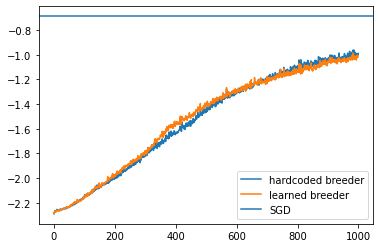

In [51]:
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne.fitdata_gens))['fitness'], axis=-1)[:, -1], label='hardcoded breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne1.fitdata_gens))['fitness'], axis=-1)[:, -1], label='learned breeder')
# plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne.fitdata_gens))['fitness'], axis=-1)[:, 0])
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['fitness'], label='SGD')
plt.legend()

In [52]:
geno = ne.pop[np.argmax(util.arr_dict2dict_arr(np.array(ne.fitdata_gens))['fitness'][-1])]

In [56]:
net = geno.load_pheno(models_decode.IdentityDecoder(), models_pheno.SmallNet().to(device))

task.perform_stats(net, device=device)

Average Loss: 1.037, Accuracy: 67.170%


{'loss': 1.036720621585846, 'accuracy': 67.17}

In [61]:
(1e-2*torch.randn(130)).norm(dim=-1)

tensor(0.1091)

In [61]:
import population

In [83]:
pheno = models_pheno.ConvNet().to(device)
decoder = models_decode.IdentityDecoder()

fits = np.zeros((2, 2, 1000))
for nei, ne in enumerate([ne1, ne2]):
    for bi, breeder in enumerate([models_breed.AverageBreeder(), models_breed.RandomSwapBreeder()]):
        prob = population.fit2prob_sm(ne.fitdata['fitness'], fit2prob_sm_iT=1., fit2prob_sm_normalize=False)
        for i in tqdm(range(1000)):
            geno1, geno2 = np.random.choice(ne.pop, size=(2), p=prob)
            dna = breeder.breed_dna(geno1.dna, geno2.dna)
            geno = neuroevolution.CombinedGenotype(dna, geno1.decoder_dna, geno1.breeder_dna)
            pheno = geno.to_pheno(decoder, pheno)
            fits[nei, bi, i] = task.calc_pheo_fitness(pheno, device=device)['fitness']


(-1.3, -0.7)

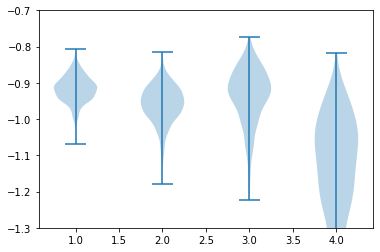

In [84]:
plt.violinplot(fits.reshape(4, 1000).T);
plt.ylim(-1.3, -.7)

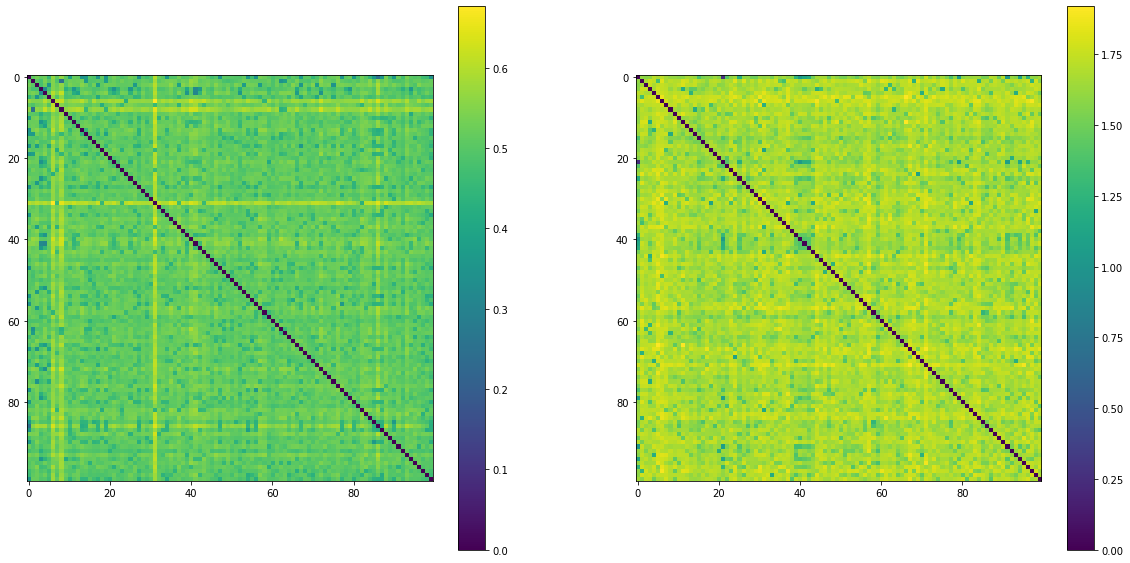

In [82]:
plt.figure(figsize=(20,10))
for nei, ne in enumerate([ne1, ne2]):
    plt.subplot(1,2,nei+1)
    a = torch.stack([geno.dna for geno in ne.pop]).cpu()
    plt.imshow((a[:, None] - a[None, :]).norm(dim=-1).numpy())
    plt.colorbar()


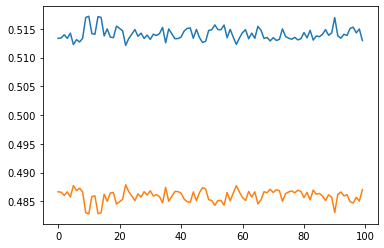

In [40]:
plt.plot(np.stack([geno.breeder_dna.cpu().softmax(dim=-1).numpy() for geno in ne.pop]))
# plt.scatter(np.ones(2), ne.pop[0].breeder_dna.cpu().softmax(dim=-1).numpy())

In [7]:
torch.manual_seed(0)
np.random.seed(0)
geno_config = {
    'pheno_class': models_pheno.SmallNet,
    'decoder_class': models_decode.LinearDecoder,
    'breeder_class': models_breed.LinearBreeder,
    
    'dna_mutate_lr': 1e-2,
    'dna_mutate_prob': 0,
    
    'decode_mutate_lr': 1e-2,
    'decode_mutate_prob': 0,
    'decode_weight_init_zeros': False,
    
    'breed_mutate_lr': 1e-3,
    'breed_mutate_prob': 0,
    'breed_weight_init_for_first_parent': False,
    
    'dna_len': 20,
    'dna_init_std': 1e-1,
}

evol_config = {
    'fitness_func': task.calc_pheo_fitness,
    'n_pop': 100,
    'n_gen': 1000,
    'prob_sm_const': 1.,
    'n_elite': 5,
    'with_replacement': True,
    'fit2prob_sm_iT': 1.,
    'fit2prob_sm_normalize': True,
    'crossover': True,
}
log_config = {
    'logger': logger,
    'tag': 'temp',
}

tag = 'temp'
# logger.add_text(tag, f'NE with config: {config}')

ne = neuroevolution.Neuroevolution(geno_config, evol_config, device=device, verbose=True)
ne.run_evolution(tqdm=tqdm, logger=logger, tag=tag)

# logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
# logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

Running Neuroevolution with 
Population:  100
Generations:  1000
Pheno   # params: 00130
------------------
DNA     # params: 00020
Decoder # params: 02730
Breeder # params: 00820
Total   # params: 03570


engineering_stats device


genome_stats
pheno_class decoder_class breeder_class
init_stats
mutate_stats

evolution_stats
fitness_func
reproduction_stats


I want to be able to:
- change how geno represents the pheno
- change how population mutation, crossover, fitness is batched
- change how evolution over time is done

In [13]:
run_idx = 0
for trial_idx in range(5):
    for breed_mutate_lr in [0, 1e-4, 1e-2]:
        for breed_weight_init_for_first_parent in [True, False]:
            run_idx += 1
            torch.manual_seed(trial_idx)
            np.random.seed(trial_idx)
            batch_idx = 21
            config = {
                'breed_weight_init_for_first_parent': breed_weight_init_for_first_parent,
                'mutate_lr': 1e-2,
                'mutate_prob': 1e-3,
                'breed_mutate_lr': breed_mutate_lr,
                'breed_mutate_prob': 0,
                'n_pop': 100,
                'n_gen': 500,
                'prob_sm_const': 1.,
                'n_elite': 5,
                'with_replacement': True,
            }
            tag = f'run {run_idx:03d}'
            logger.add_text(tag, f'Trial {trial_idx}, NE with config: {config}')
            
            ne = neuroevolution.Neuroevolution(models.SmallNet, Breeder, calc_pheo_fitness, config, device=device)
            ne.run_evolution(tqdm=tqdm, logger=logger, tag=tag)
            
#             logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
            logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

KeyboardInterrupt: 

In [13]:
import co_crossover_ne

ne = co_crossover_ne.COCrossoverNE(models.SmallNet, CONet, calc_pheo_fitness, config, device=device)

ne.run_evolution(tqdm=tqdm, logger=logger)

TypeError: __init__() missing 1 required positional argument: 'config'

In [29]:
first_parent_weight_init=True

In [18]:
torch.manual_seed(0)
conet = CONet(config).to(device)
a = torch.randn_like(v).to(device)
b = torch.randn_like(v).to(device)
c = conet.crossover(a, b).detach()
(c-a).abs().max().item(), (c-b).abs().max().item()

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)


(0.0, 3.999563694000244)

In [ ]:

def calc_pheo_fitness(net):
    global batch_idx
#     batch_idx, (X_batch, Y_batch) = next(enumerate(mnist.train_loader))
    X_batch, Y_batch = X_train[batch_idx].to(device), Y_train[batch_idx].to(device)
    batch_idx = (batch_idx+1)%len(X_train)
    
#     Y_batch_pred, bef, aft = net(X_batch)
    Y_batch_pred = net(X_batch)
    n_correct = (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
    loss = mnist.loss_func(Y_batch_pred.log(), Y_batch).item()
    if not np.isfinite(loss):
        for i in range(len(Y_batch_pred)):
            loss = mnist.loss_func(Y_batch_pred[[i]].log(), Y_batch[[i]]).item()
            if not np.isfinite(loss):
                temp = Y_batch_pred[[i]].detach().cpu().numpy()
                plt.bar(np.arange(10), temp.flatten())
                plt.show()
                plt.imshow(X_batch[[i]].cpu().numpy()[0,0])
                plt.show()
                print(temp)
                print(Y_batch[[i]])
                plt.subplot(132)
                temp = list(net.parameters())[-2].detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.subplot(133)
                temp = bef[[i]].T.detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.subplot(131)
                temp = aft[[i]].detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.show()
                temp = aft[[i]].detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.show()
                raise Exception()
        
        
    accuracy = n_correct/len(Y_batch)
    
    return {'fitness': -loss, 'loss': loss, 'accuracy': accuracy}


In [40]:
for a_idx, amount in enumerate(amounts):
    print(f'mean: {data[:, a_idx, -1].mean(dim=0): .3f}, std: {data[:, a_idx, -1].std(dim=0):.3f}, amount:{amounts[a_idx]: .1e}')

mean: -0.523, std: 0.497, amount: 1.0e-09
mean: -0.480, std: 0.197, amount: 1.0e-03
mean: -0.577, std: 0.182, amount: 1.0e-02
mean: -0.341, std: 0.111, amount: 1.0e-01
mean: -0.355, std: 0.136, amount: 1.0e+00
mean: -0.342, std: 0.147, amount: 1.0e+01


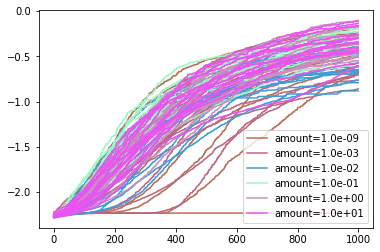

In [24]:
for a_idx, amount in enumerate(amounts):
    c = np.random.uniform(size=3)
    for trial_idx in range(15):
        label=None
        if trial_idx==0:
            label=label=f'amount={amount:.1e}'
        plt.errorbar(np.arange(1000), data[trial_idx, a_idx].numpy(), yerr=None, c=c, label=label)
plt.legend()

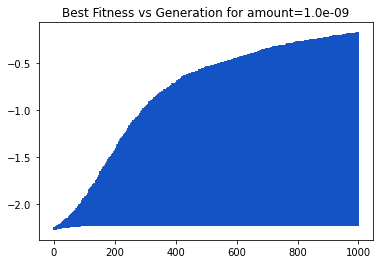

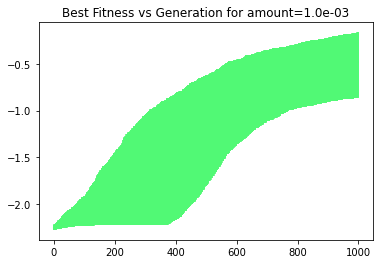

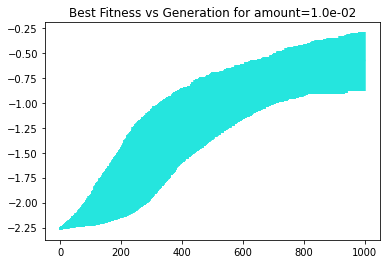

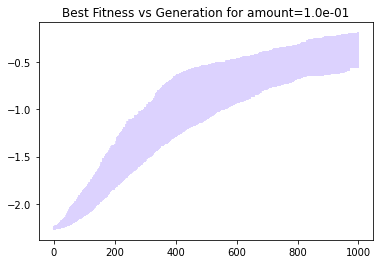

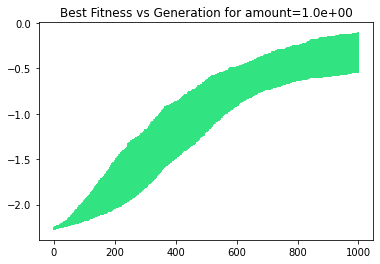

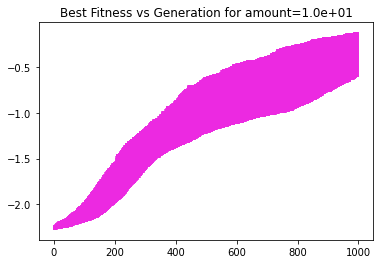

In [28]:
for a_idx, amount in enumerate(amounts):
    c = np.random.uniform(size=3)
    label=label=f'amount={amount:.1e}'
    d = data[:, a_idx]
    yerr = d.std(dim=0)
    yerr = torch.stack([d.min(dim=0).values-d.mean(dim=0), d.max(dim=0).values-d.mean(dim=0)], dim=0).abs()
    plt.errorbar(np.arange(1000), d.mean(dim=0).numpy(),
                 yerr=yerr.numpy(), c=c, label=label)
    plt.title(f'Best Fitness vs Generation for amount={amount:.1e}')
    plt.show()
# plt.legend()

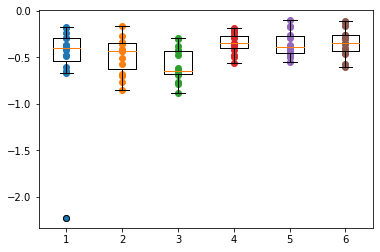

In [56]:
# for a_idx, amount in enumerate(amounts):
#     plt.boxplot(data[:, a_idx, -1].numpy())
plt.boxplot(data[:, :, -1].numpy())

for a_idx, amount in enumerate(amounts):
    d = data[:, a_idx, -1]
    plt.scatter(np.ones_like(d)*(a_idx+1), d.numpy())
plt.show()

In [30]:
data.numel()

90000

torch.Size([15, 3, 500])

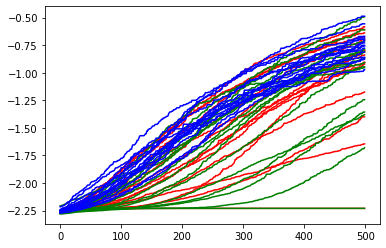

In [53]:
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 0].numpy(), yerr=None, c='r')
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 1].numpy(), yerr=None, c='g')
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 2].numpy(), yerr=None, c='b')
d.shape